![PyTorch logo](img/pytorch.jpg)

# From dummy to state-of-the-art
By José Fernández Portal

## Agenda
- Introduction.
- Three perspectives of PyTorch:
 1. Numpy with superpowers.
 2. A Deep Learning library.
 3. A great fundation to build on top of.

## Target audience
This tutorial assumes audience is familiarized with:
- Python, particularly Numpy.
- Neural nets (layers, loss functions, backprop, SGD, etc.).

## Introduction

### What is Pytorch?
- Open-source Deep Learning library.
- Developed by Facebook AI Team.
- Alternative to TensorFlow/Keras.

### Why PyTorch?
Let’s dig into the code and try to find it out together...

## 1. Numpy with superpowers

At first sight PyTorch is a numeric computation library similar to Numpy.

So, let's start by importing PyTorch.

In [1]:
import torch

### 1.1. Basic operations

Indeed, it will feel very familiar to Numpy's users...

PyTorch's tensors are almost equivalent to Numpy's arrays.

In [2]:
a = torch.tensor([[5., 3], [4, 1], [3, 6]])   # np.array(...)
a, a.shape

(tensor([[5., 3.],
         [4., 1.],
         [3., 6.]]), torch.Size([3, 2]))

In [3]:
b = torch.rand(2, 4)

In [4]:
c = a @ b   # short version of torch.matmul(...)
c

tensor([[3.0264, 4.9774, 1.5235, 4.0556],
        [1.0651, 3.7087, 0.5306, 3.0298],
        [5.8839, 3.8061, 2.9786, 3.0773]])

In [5]:
c.argmax(dim=1)

tensor([1, 1, 0])

#### Numpy bridge

In [6]:
import numpy as np

Going back and forth between PyTorch and Numpy is straightforward.

In [7]:
a1 = np.random.rand(2, 2)
a1

array([[ 0.87744065,  0.00470322],
       [ 0.01412647,  0.93488982]])

By using `from_numpy` method, you can create a tensor from a Numpy's array.

In [8]:
t = torch.from_numpy(a1)
t

tensor([[0.8774, 0.0047],
        [0.0141, 0.9349]], dtype=torch.float64)

Similarly, `numpy` method allows to create a Numpy's array from a tensor.

In [9]:
a2 = (t*2).numpy()
a2

array([[ 1.75488131,  0.00940644],
       [ 0.02825294,  1.86977963]])

### 1.2. GPU acceleration (1st superpower)

By using PyTorch we can leverage on GPU computing power.

Let's compare the performance of a matrix product between Numpy and PyTorch.

In [10]:
N = 10000 # matrix size

#### Numpy

Define two large Numpy's arrays.

In [11]:
a = np.random.rand(N, N)
b = np.random.rand(N, N)

Multiplying them can we quite slow...

In [12]:
%time c = a @ b

CPU times: user 4min, sys: 5.43 s, total: 4min 5s
Wall time: 31 s


#### PyTorch on CPU

Let's do the same operation in Python

In [13]:
a = torch.rand(N, N)
b = torch.rand(N, N)

In [14]:
%time c = a @ b

CPU times: user 16.7 s, sys: 144 ms, total: 16.8 s
Wall time: 4.21 s


It was faster, but we can do make it even faster...

#### PyTorch on GPU (CUDA)

CUDA: "Compute Unified Device Architecture" (Nvidia's GPU propieraty technology).

By default, tensors operations are performed on the CPU...

In [15]:
a = torch.rand(N, N)
b = torch.rand(N, N)
a.device, b.device

(device(type='cpu'), device(type='cpu'))

But, you can move tensors to GPU by using the `cuda` method.

In [16]:
if torch.cuda.is_available():
    a, b = a.cuda(), b.cuda()
a.device, b.device

(device(type='cuda', index=0), device(type='cuda', index=0))

Now that tensors live on GPU, we can perform the matrix product again.

In [17]:
%time c = a @ b

CPU times: user 0 ns, sys: 11.4 ms, total: 11.4 ms
Wall time: 10.7 ms


WOW! As you can see, computations are way faster on GPU!

In [18]:
c.device

device(type='cuda', index=0)

Tensors can be moved back to CPU by using the `cpu` method.

In [19]:
c = c.cpu()
c.device

device(type='cpu')

### 1.3. Automatic differentiation (2nd superpower)

When training Neural Nets, in order to perform backprop, it is required to compute the weights' gradients.

PyTorch's Autograd functionality can track for us all the operations applied to a tensor and provides automatic differentiation.

By specifing `requires_grad=True` on a tensor, we can require PyTorch to track its gradients.

In [20]:
x = torch.arange(4., requires_grad=True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

Let's now apply a serie of operations to the tensor.

In [21]:
y = x.pow(2)
y.mul_(5)
y.add_(3)
y = y.mean()
# equivalent to: y = (5 * x**2 + 3).mean()

So, out function look as follow:

\begin{align} y = f(x) = \frac{1}{4} \sum_{i=1}^4 5 x_i ^ 2 + 3 \end{align}

If we check the gradient, it is empty by now.

In [22]:
x.grad

By calling `y.backward()`, PyTorch computes the gradient of *y* with respect to the each dependant variable with `requires_grad=True`.

In [23]:
y.backward()
x.grad

tensor([0.0000, 2.5000, 5.0000, 7.5000])

You can verify the gradient analytically:
\begin{align}
\frac{\partial y}{\partial x_i} = 
\frac{5 x_i}{2} 
\end{align}

By default, PyTorch accumulates the gradient when calling `backward()` multiple times, so it's important to reset the gradient after calling `backward()`.

In [24]:
x.grad.zero_()
x.grad

tensor([0., 0., 0., 0.])

### 1.4. Our first Neural Net

We now have the tools to build our first Neural Net.

In [25]:
import matplotlib.pyplot as plt

Let's start by creating a toy dataset with a linear distribution.

Note that if we have a GPU available (`torch.cuda.is_available()==True)`), Pytorch will make use of it.

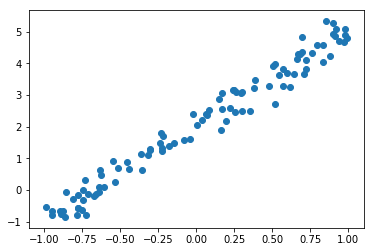

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x = torch.rand(100, device=device) * 2 - 1
y = 3 * x + 2 + torch.randn(100, device=device) * 0.3
plt.scatter(x.cpu(), y.cpu());

Now, we will define a linear regressor model and initialize the coeficient a and b to -1 and 1, respectively.

In [27]:
def model(x): return x * a + b

a0 = -1.; b0 = 1.
a = torch.tensor(a0, requires_grad=True, device=device)
b = torch.tensor(b0, requires_grad=True, device=device)

We have not trained the model yet, so it is predicting poorly.

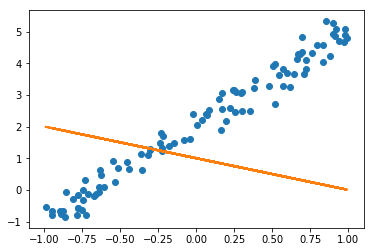

In [28]:
plt.scatter(x.cpu(), y.cpu())
plt.plot(x.cpu().numpy(), model(x).data.cpu().numpy(), c='C1', linewidth=2);

To train the model we will need a loss function. We will use the Mean Squared Error (MSE).

In [29]:
def mse(input, target): return ((input - target)**2).mean()

We are ready to train now. During the training, on every epoch we will perform 4 steps:
1. Predict, using our model.
2. Compute the loss, using the loss function.
3. Compute the gradients, calling the `backward()` method.
4. Update the weights (a & b) using its gradients. Two comments on this step:
 - After using the gradients, and before calling `backward` again, it is important to reset the gradients (`<variable>.grad.zero_()`)
 - Note that the weights (a & b) are updated inside a `torch.no_grad()` block. This prevents that PyTorch tracks the gradients of these manual updates.

In [30]:
lr = 1e-1
epochs = 100

for i in range(epochs):
    y_hat = model(x)            # predict
    loss = mse(y_hat, y)        # compute loss
    loss.backward()             # backprop
    with torch.no_grad():
        a -= a.grad * lr        # adjust a
        b -= b.grad * lr        # adjust b
    a.grad.zero_()          
    b.grad.zero_()          

Now, we can verify that our model is propertly trained.

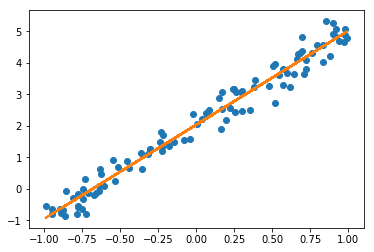

In [31]:
plt.scatter(x.cpu(), y.cpu())
plt.plot(x.cpu().numpy(), model(x).data.cpu().numpy(), c='C1', linewidth=2);

## 2. A Deep Learning framework

PyTorch is also a very powerful and flexible Deep Learning Framework, that allow to create and train Neural Networks easily.

So, let's create a simple Neural Net for the MNIST dataset (handwritten digits) using Pytorch's full functionalities.

### 2.1. Data

In [32]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path

In [33]:
MNIST_PATH = Path('~/datasets/mnist_png').expanduser()

#### Transform
The `Transform` class allows to adapt the data to fit into our model. For this dataset, we need to transform images to grayscale (single channel), turn imagenes into tensors and normalize values according dataset's mean and standard deviation.

In [34]:
tfms = transforms.Compose([
           transforms.Grayscale(),
           transforms.ToTensor(),
           transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

Transformations are used to perform data augmentation as well.

#### Datasets

Datasets help us loading data to then feed our model. PyTorch provides different kinds of datasets for specific types of data, or you can even create your custom dataset when required.

In [35]:
!ls {MNIST_PATH/'train'}

0  1  2  3  4  5  6  7	8  9


Since in this dataset images are organized by labels in folder, we can use Pytorch's `ImageFolder` dataset class to load our data easily.

In [36]:
train_ds = torchvision.datasets.ImageFolder(MNIST_PATH/'train', tfms)
valid_ds = torchvision.datasets.ImageFolder(MNIST_PATH/'test', tfms)
len(train_ds), len(valid_ds), train_ds.classes

(60000, 10000, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

We can retrieve some random sample for the dataset.

In [37]:
idx = torch.randperm(len(train_ds))[0] # random sample
x, y = train_ds[idx]
x.shape, y

(torch.Size([1, 28, 28]), 3)

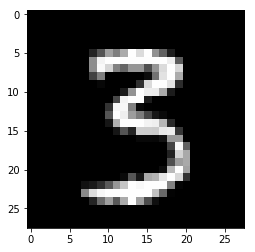

In [38]:
plt.imshow(x.squeeze(), cmap='binary_r');

#### Dataloaders

A dataloader turns a dataset into a generator that yield data in batches. It is ideal to perform Stochastic Gradient Descent (or any its variant), specially when training on GPU where only limited amount of data can fit into memory.

In [39]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=False, num_workers=8)

We can easily grab and visualize one batch.

In [40]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

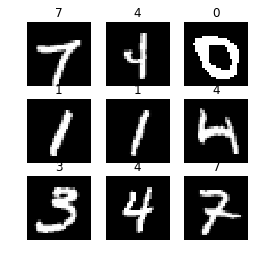

In [41]:
fig, axes = plt.subplots(3, 3, figsize=(4, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(xb[i].squeeze(), cmap='binary_r');
    ax.set_title(yb[i].item())
    ax.axis('off')

### 2.2. Model

`torch.nn` and `torch.nn.functional` provide handy classes and functions to create custom Neural Nets.

In [42]:
import torch.nn as nn
import torch.nn.functional as F

In [43]:
class Flatten(nn.Module): 
    def forward(self, x): return x.view(x.shape[0], -1)

PyTorch provides two alternatives APIs to define a model. We can use any of them:
- Declarative API: for simple sequential models, you can use `nn.Sequential` to specify the layers of your Neural Net.

In [44]:
model = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(4),
                      Flatten(),
                      nn.Linear(64, 10))

- Functional API: to create customized models/layers. Some considerations:
  - Implement a class that inherites from `nn.Module`.
  - In the `__init__` method, define your persistant layers (layers that store weights).
  - Override the `forward` method, defining the workflow of your forward pass.
  - `backward` method is generated automatically by Pytorch.

In [45]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.lin = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 4)
        x = Flatten()(x)
        return self.lin(x)

In [46]:
model = Model()

Let's move the model to GPU, if available.

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

To check that our model is working, we can pass a batch to our model.

In [48]:
# sanity check
xb = xb.to(device)
pred = model(xb)
pred.shape

torch.Size([256, 10])

### 2.3. Train

`torch.optim` module provides optimization algorithms, such as SGD, Adam, etc.

In [49]:
import torch.optim as optim

Define the hyper-parameters for our model.

In [50]:
lr = 3e-3
epochs = 5

Define the loss function, optimizer and metric that we want to use.

In [51]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr)

In [52]:
def accuracy(input, target):
    preds = input.argmax(dim=1)
    return (preds==target).float().mean().item()

And finally, our training loop.

In [53]:
def fit(model, train_dl, valid_dl, loss_func, opt):
    print(f'epoch  train_loss  valid_loss  train_acc  valid_acc')
    for epoch in range(epochs):
        train_loss, valid_loss, train_acc, valid_acc = 0., 0., 0., 0.

        model.train()  # *** TRAINING ***
        for xb,yb in train_dl:                    # iterate every batch
            xb,yb = xb.to(device), yb.to(device)  # move features & target to GPU
            pred = model(xb)                      # predict
            loss = loss_func(pred, yb)            # compute loss
            loss.backward()                       # backprop
            opt.step()                            # adjust weights
            opt.zero_grad()   
            train_loss += loss.item() * len(xb)
            train_acc += accuracy(pred, yb) * len(xb)

        model.eval()  # *** VALIDATION ***
        for xb,yb in valid_dl:
            xb,yb = xb.to(device), yb.to(device)
            with torch.no_grad(): 
                pred = model(xb)
            loss = loss_func(pred, yb)
            valid_loss += loss.item() * len(xb)
            valid_acc += accuracy(pred, yb) * len(xb)

        # compute metrics and print
        train_loss /= len(train_ds)
        valid_loss /= len(valid_ds)
        train_acc /= len(train_ds)
        valid_acc /= len(valid_ds)
        print(f'{epoch+1:<7}{train_loss:<12.4f}{valid_loss:<12.4f}' +
              f'{train_acc:<11.4f}{valid_acc:<11.4f}')

Let's train!

In [54]:
%%time
fit(model, train_dl, valid_dl, loss_func, opt)

epoch  train_loss  valid_loss  train_acc  valid_acc
1      0.3869      0.1289      0.8835     0.9593     
2      0.1047      0.0742      0.9678     0.9773     
3      0.0744      0.0645      0.9770     0.9803     
4      0.0567      0.0608      0.9823     0.9811     
5      0.0481      0.0548      0.9845     0.9829     
CPU times: user 4.48 s, sys: 2 s, total: 6.48 s
Wall time: 12.2 s


## Predict

Fetch one random sample from validatoin set.

In [59]:
idx = torch.randperm(len(valid_ds))[0] # random sample
x,_ = valid_ds[idx]
xb = x[None]

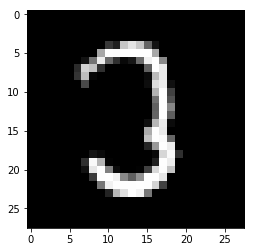

In [60]:
plt.imshow(x.squeeze(), cmap='binary_r');

Let's use our trained model to make a prediction.

In [61]:
xb = xb.to(device)
pred = model(xb)
pred.argmax(1).item()

3

## 3. A great foundation to build on top of

PyTorch it self is great! But it is not alone... Is is the foundation of a rich ecosystem of tools and libraries that makes PyTorch even greater.

Introducing...

![fastai logo](img/fastai.png)

The [fastai library](https://docs.fast.ai/) simplifies training fast and accurate neural nets using modern best practices. Fastai sits on top of PyTorch and it's based on research in to deep learning best practices undertaken at [fast.ai](https://www.fast.ai), including "out of the box" support for vision, text, tabular, and collab (collaborative filtering) models.

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
PETS_PATH = Path('~/datasets/oxford-iiit-pet/images').expanduser()

### 3.1. Data

We will use the Oxford-IIIT Pet dataset, that contains images of 37 breeds of dogs and cats.

Fastai's `data_block` allows to load data, split train/valid sets, label, transform and normalize in just one step.

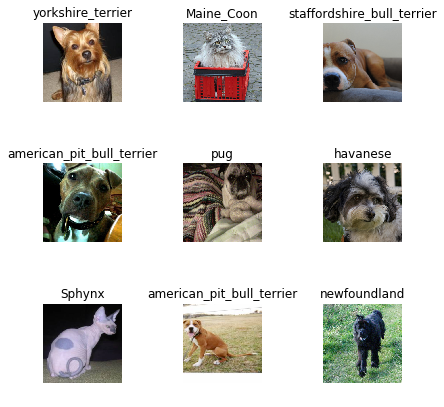

In [3]:
data = (ImageItemList.from_folder(PETS_PATH)
        .random_split_by_pct(0.1, seed=7)
        .label_from_func(lambda fn: fn.name.rsplit('_', 1)[0])
        .transform(get_transforms(), size=354)
        .databunch(bs=32)
        .normalize(imagenet_stats))
data.show_batch(rows=3, figsize=(6,6))

### 3.2. Model & train

We can create a state-of-the-art model in just one line.

In [4]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

It also helps us picking the optimal learning rate (you can read more about this technique on fastai's documentation).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


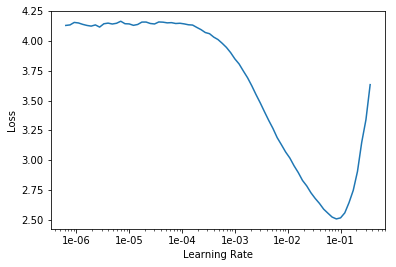

In [5]:
learn.lr_find()
learn.recorder.plot()

Again, train the model requires just one line of code.

In [6]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,0.555982,0.334226,0.889039
2,0.378583,0.187964,0.941813
3,0.194831,0.151461,0.949932


In [7]:
learn.save('stage-1')

Optionally, we can fine-tune our model easily.

In [8]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.171513,0.152492,0.945873
2,0.145948,0.137371,0.959405


WOW! It doesn't sound like a trivial task to classify among 37 breads of dogs and cats with a 95% accuracy... I guess this model can outperform most humans on this task!

In [9]:
learn.save('stage-2')

In [10]:
learn.load('stage-2');

If we visualize the model, we can see that it is pure PyTorch.

In [58]:
#learn.model

### 3.3. Predict

Let's try with Bruno, my dog.

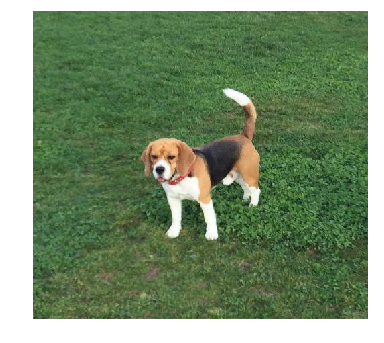

In [12]:
img = open_image('img/bruno.jpg',)
img.show(figsize=(6,6))

In [13]:
cat,y,probs = learn.predict(img)
cat, probs[y]

(Category beagle, tensor(0.9998))

Great! Bruno is indeed a beagle.

### 3.4. Bonus: Opening the black box...

We now have a state-of-the-art model. But, as a bonus, we can make a couple of cool stuffs that will help us visualize the power of PyTorch and fastai and, by the way, understand Neural Nets a little bit more.

**Disclaimer:** This section is based on [this notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb) from Fastai course.

PyTorch's hooks allow to obtain activations and gradients of any given layer. In this case, we will hook the convotutional section of the NN.

In [14]:
from fastai.callbacks.hooks import hook_output

In [15]:
def get_hooks(label=None):
    conv_model = learn.model[0]
    xb = data.one_item(img)[0]
    if not label: label = y
    with hook_output(conv_model) as hook_acts:
        with hook_output(conv_model, grad=True) as hook_grad:
            pred = learn.model(xb.cuda())
            pred[0, label].backward()
    return hook_acts.stored[0], hook_grad.stored[0]

#### Visualizing activations

In [16]:
acts, _ = get_hooks()
acts.shape

torch.Size([2048, 12, 12])

These activations represent how different locations of the image activate each of the 2048 features.

If we average the activation across the features axis, we get a mean activation by location.

In [17]:
hm = acts.mean(0)
hm.shape

torch.Size([12, 12])

We can then use this activation map to plot a heatmap and find out the areas of the image that are relevant for the classification.

In [18]:
def show_heatmap(img, hm):
    _, ax = plt.subplots(figsize=(6,6))
    xb_img = Image(data.one_item(img, denorm=True)[0][0])
    xb_img.show(ax)
    ax.imshow(hm, extent=(0,*xb_img.size,0), interpolation='bilinear', 
              alpha=.7, cmap='magma');

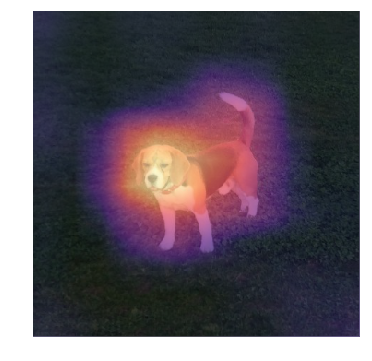

In [19]:
show_heatmap(img, hm)

Let's try something harder...

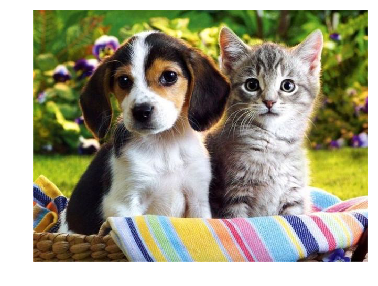

In [20]:
img = open_image('img/beagle-mayne.jpg')
img.show(figsize=(6, 6))

The model is classifying the image as 'beagle'.

In [21]:
cat,y,prob = learn.predict(img)
cat

Category beagle

We can plot the activation heatmap again.

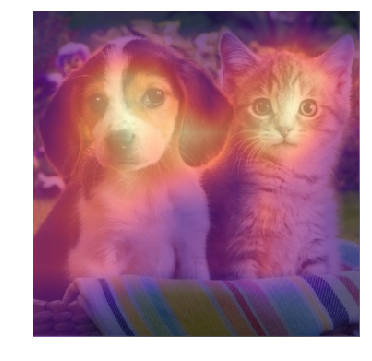

In [22]:
acts, _ = get_hooks()
hm = acts.mean(0)
show_heatmap(img, hm)

We can see that both the dog and the cat are creating strong activations...

So, what the model does in this situation?

#### Visualizing gradients


[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In our previous analysis, we just averaged the features. However, we can go an step forward and try to use the relative importance of each feature when predicting an specific target.

So, this time we will use the gradients to weight each feature.

In [23]:
acts, grad = get_hooks()
avg_grad = grad.squeeze().mean(1).mean(1)
hm = (acts * avg_grad[:,None,None]).mean(0)

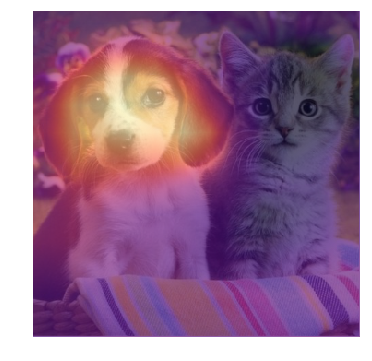

In [24]:
show_heatmap(img, hm)

The heatmap now clearly highlights the area that contibutes the most to label the image as a beagle (the gradients are weighting beagle's features stronger).

But, what if we now tell explicitly to out net that this image should be classified as an Maine Coon instead of a Beagle?

In [25]:
y = data.classes.index('Maine_Coon')

In [26]:
acts, grad = get_hooks(y)
avg_grad = grad.squeeze().mean(1).mean(1)
hm = (acts * avg_grad[:,None,None]).mean(0)

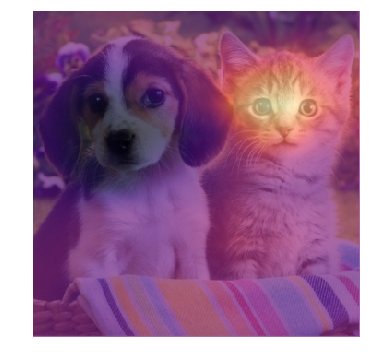

In [27]:
show_heatmap(img, hm)

BOOM! The gradients now weights stronger the cat's features!

## Takeaways

- PyTorch provides a pythonic way of doing Deep Learning.
- Easy, flexible & powerful.
- Fullstack Deep Learning (no magic).
- Fastai is awesome!

## End